# Tarea 6 EL7008 - Segmentación semántica en dataset Kitti. 

## Desarrollo por Joaquin Zepeda V.

El objetivo de esta tarea es entrenar y probar un sistema de segmentación semántica basado en U-net. El dataset a usar es Kitti, el cual contiene 200 imágenes de entrenamiento etiquetadas píxel a píxel y 200
imágenes de test sin etiquetar. Las etiquetas corresponden a 11+1 clases posibles (11 clases de objetos y
una clase extra para píxeles no válidos). El dataset contiene imágenes capturadas por un vehículo en
movimiento. 

# Reducir las etiquetas

Las máscaras de Kitti contienen 31 valores posibles, los cuales deben ser reducidos a 11+1 etiquetas dentro
de la clase KittiDataset. La función kitty_inverse_map_1channel() que realiza la conversión
será entregada junto con el enunciado de la tarea.

In [1]:
!git clone https://github.com/milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 552, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 552 (delta 7), reused 14 (delta 4), pack-reused 531
Receiving objects: 100% (552/552), 47.41 MiB | 30.00 MiB/s, done.
Resolving deltas: 100% (284/284), done.


In [2]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 4.7 MB/s 
     |████████████████████████████████| 168 kB 50.3 MB/s 
     |████████████████████████████████| 182 kB 57.2 MB/s 
     |████████████████████████████████| 62 kB 885 kB/s 
     |████████████████████████████████| 168 kB 57.0 MB/s 
     |████████████████████████████████| 166 kB 64.5 MB/s 
     |████████████████████████████████| 166 kB 64.4 MB/s 
     |████████████████████████████████| 162 kB 65.1 MB/s 
     |████████████████████████████████| 162 kB 44.6 MB/s 
     |████████████████████████████████| 158 kB 60.0 MB/s 
     |████████████████████████████████| 157 kB 61.8 MB/s 
     |████████████████████████████████| 157 kB 58.2 MB/s 
     |████████████████████████████████| 157 kB 45.4 MB/s 
     |████████████████████████████████| 157 kB 53.6 MB/s 
     |████████████████████████████████| 157 kB 73.4 MB/s 
     |████████████████████████████

# Descargamos el Dataset

In [3]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2022-12-03 20:03:40--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.72.239
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.72.239|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  26.6MB/s    in 13s     

2022-12-03 20:03:53 (24.4 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



In [4]:
%cd Pytorch-UNet/

/content/Pytorch-UNet


In [5]:
!unzip ../data_semantics.zip

Archive:  ../data_semantics.zip
   creating: testing/
   creating: testing/image_2/
  inflating: testing/image_2/000000_10.png  
  inflating: testing/image_2/000001_10.png  
  inflating: testing/image_2/000002_10.png  
  inflating: testing/image_2/000003_10.png  
  inflating: testing/image_2/000004_10.png  
  inflating: testing/image_2/000005_10.png  
  inflating: testing/image_2/000006_10.png  
  inflating: testing/image_2/000007_10.png  
  inflating: testing/image_2/000008_10.png  
  inflating: testing/image_2/000009_10.png  
  inflating: testing/image_2/000010_10.png  
  inflating: testing/image_2/000011_10.png  
  inflating: testing/image_2/000012_10.png  
  inflating: testing/image_2/000013_10.png  
  inflating: testing/image_2/000014_10.png  
  inflating: testing/image_2/000015_10.png  
  inflating: testing/image_2/000016_10.png  
  inflating: testing/image_2/000017_10.png  
  inflating: testing/image_2/000018_10.png  
  inflating: testing/image_2/000019_10.png  
  inflating: tes

# Cargar los datos, clase KittiDataset

In [6]:
# Esta funcion debe ser copiada a una celda de colaboratory para poder usarla

from numba import jit
@jit(nopython=True)
def kitti_inverse_map_1channel(img):
  cmap = [
    (0, 0), #void (ignorable) 
    (4, 0),
    (5, 0),
    (6, 0),
    (7, 1), #road
    (8, 2), #sidewalk
    (9, 2),
    (10, 0), #rail truck (ignorable)
    (11, 3), #construction
    (12, 3),
    (13, 3),
    (14, 3),
    (15, 3),
    (16, 3),
    (17, 4), #pole(s)
    (18, 4),
    (19, 5), #traffic sign
    (20, 5),
    (21, 6), #vegetation
    (22, 6),
    (23, 7), #sky
    (24, 8), #human
    (25, 8),
    (26, 9), #vehicle
    (27, 9),
    (28, 9),
    (29, 9),
    (30, 9),
    (31, 10), #train
    (32, 11), #cycle
    (33, 11)
  ]  

  arrmap = np.zeros( (34), dtype=np.int32 )

  for el in cmap:
    arrmap[el[0]] = el[1]

  val = np.ones((img.shape[0],img.shape[1]), dtype=np.int32) * -1

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      val[i,j] = arrmap[img[i,j]]
  return val

In [7]:
from os.path import splitext
from os import listdir
import numpy as np
from glob import glob
import torch
from torch.utils.data import Dataset
import logging
from PIL import Image

class KittiDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, read_mask, scale=1, mask_suffix=''):

        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.read_mask = read_mask
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    @classmethod
    def do_transpose(cls, img_nd):
        img_trans = img_nd.transpose((2, 0, 1))
        return img_trans


    def __getitem__(self, i):
        name = self.ids[i]  
        idx = self.ids[i]
        if self.read_mask:
           mask_file = list(self.masks_dir.glob(name + self.mask_suffix + '.*'))   #mask_file = glob(self.masks_dir + idx + self.mask_suffix + '.*')
        img_file = list(self.imgs_dir.glob(name + '.*'))    #img_file = glob(self.imgs_dir + idx + '.*')

        #print(mask_file[0])
        #print(img_file[0])

        if self.read_mask != None:
          assert len(mask_file) == 1, \
              f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
          mask = Image.open(mask_file[0])

        assert len(img_file) == 1, \
            f'Either no image or multiple images found for the ID {idx}: {img_file}'
 
        img = Image.open(img_file[0])

        if self.read_mask != None:
          assert img.size == mask.size, \
            f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'

        if self.read_mask == 'rgb':
          #print('Calling inverse map rgb...')
          mask = kitti_inverse_map(np.array(mask, dtype=np.int32))
          #print('Ok inverse map rgb...')
        if self.read_mask == 'gray':
          #print('Calling inverse map gray...')
          mask = kitti_inverse_map_1channel(np.array(mask, dtype=np.int32))
          #print('Ok inverse map gray...')

        #print(np.array(mask))

        img = self.preprocess(img, self.scale)

        if self.read_mask != None:
          #mask = mask[0:370, 0:1224]   #(370, 1224, 3)
          mask_torch = torch.from_numpy(mask).type(torch.IntTensor)
        else:
          mask_torch = None

        return {
            'image': torch.from_numpy(img).type(torch.FloatTensor),
            'mask': mask_torch
        }


#Modelo de la red

Se debe copiar el archivo unet_model.py al notebook. Se debe reemplazar el import por el siguiente:

In [8]:
""" Full assembly of the parts to form the complete network """

from unet.unet_parts import * 

# red original para la primera parte
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# Red utilizando solo 3 capas UP y 3 capas Down
class UNet2(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet2, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        factor = 2 if bilinear else 1

        self.down3 = Down(256, 512// factor)
        
        #self.down4 = Down(512, 1024 // factor) #eliminamos la ultima capa down

        #self.up1 = Up(1024, 512 // factor, bilinear) #eliminamos la primera capa up
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        x = self.up2(x4, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# Red utilizando solo 2 capas UP y 2 capas Down
class UNet3(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet3, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        factor = 2 if bilinear else 1
        self.down2 = Down(128, 256// factor)

        #self.down3 = Down(256, 512)
        #self.down4 = Down(512, 1024 // factor) #eliminamos la ultima capa down

        #self.up1 = Up(1024, 512 // factor, bilinear) #eliminamos la primera capa up
        #self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)

        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        #x4 = self.down3(x3)
        #x5 = self.down4(x4)
        #x = self.up1(x5, x4)
        #x = self.up2(x4, x3)
        x = self.up3(x3, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

#Funciones de pérdida
Se debe almacenar el valor de la función de pérdida, tanto de entrenamiento como de validación, cada vez
que se llame a la función evaluate(). Para lograr esto, se entregará un archivo modificado evaluate.py,
el cual se debe copiar a una celda del notebook. Además de esto, se debe implementar el cálculo del valor
promedio de la función de pérdida de entrenamiento promedio, sobre todos los batches de entrenamiento
procesados hasta el momento en cada época.

In [9]:
!ls

data	    evaluate.py  LICENSE     README.md	       scripts	training  unet
Dockerfile  hubconf.py	 predict.py  requirements.txt  testing	train.py  utils


In [10]:
#  evaluate.py
import torch
import torch.nn.functional as F
from tqdm import tqdm

from utils.dice_score import multiclass_dice_coeff, dice_coeff


def evaluate(net, dataloader, device, criterion):
    net.eval()
    num_val_batches = len(dataloader)
    dice_score = 0

    val_loss = 0

    # iterate over the validation set
    for batch in tqdm(dataloader, total=num_val_batches, desc='Validation round', unit='batch', leave=False):
        image, mask_true = batch['image'], batch['mask']
        # move images and labels to correct device and type
        image = image.to(device=device, dtype=torch.float32)
        mask_true = mask_true.to(device=device, dtype=torch.long)
        true_masks = mask_true   # PL 2022  agregado;  mask_pred en vez de masks_pred
        mask_true = F.one_hot(mask_true, net.n_classes).permute(0, 3, 1, 2).float()

        with torch.no_grad():
            # predict the mask
            mask_pred = net(image)

            # PL 2022  agregado;  mask_pred en vez de masks_pred
            loss = criterion(mask_pred, true_masks) \
                    + dice_loss(F.softmax(mask_pred, dim=1).float(),
                                F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float(),
                                multiclass=True)
                    
            val_loss = val_loss + loss.item() # PL 2022

            # convert to one-hot format
            if net.n_classes == 1:
                mask_pred = (F.sigmoid(mask_pred) > 0.5).float()
                # compute the Dice score
                dice_score += dice_coeff(mask_pred, mask_true, reduce_batch_first=False)
            else:
                mask_pred = F.one_hot(mask_pred.argmax(dim=1), net.n_classes).permute(0, 3, 1, 2).float()
                # compute the Dice score, ignoring background
                dice_score += multiclass_dice_coeff(mask_pred[:, 1:, ...], mask_true[:, 1:, ...], reduce_batch_first=False)

           
    net.train()

    # Fixes a potential division by zero error
    if num_val_batches == 0:
        return dice_score
    return dice_score / num_val_batches, val_loss / num_val_batches

#Entrenamiento de la red
Se recomienda copiar el archivo train.py al notebook y modificarlo para poder usar el dataset Kitti,
considerando 12 clases posibles. El código en train.py ya contiene todo el código necesario para efectuar el
entrenamiento. Se deben reemplazar las líneas que crean el objeto dataset por la siguiente:
dataset = KittiDataset(dir_img, dir_mask, 'gray', img_scale)
Se debe comentar (deshabilitar) las siguientes dos líneas:
from evaluate import evaluate
from unet import UNet
Además se debe reemplazar la función get_args () por la función get_args_train() entregada en
el archivo get_args_train.py
La red, al entrenarse, recibe dos imágenes: una imagen RGB de tamaño 1x3xHxW, donde W y H es el
ancho y alto de la imagen de entrada, y una máscara de tamaño 1xHxW conteniendo las etiquetas por cada
píxel (al usar batch de tamaño 1). El objeto KittiDataset debe entregar imágenes de tamaño 3xHxW y
el DataLoader se encarga de redimensionar la imagen a 1x3xHxW. Se debe usar 2 épocas para el
entrenamiento, con un batch de tamaño 1. Se debe guardar los valores de la función de pérdida de
entrenamiento y validación para poder graficarlos posteriormente. El código base guarda un checkpoint
después de completar cada época.

In [11]:
import matplotlib.pyplot as plt7
import wandb
#!wandb login --relogin 

In [12]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from utils.dice_score import dice_loss
#from evaluate import evaluate
#from unet import UNet

dir_img = Path('./training/image_2/')
dir_mask = Path('./training/semantic/')
dir_checkpoint = Path('./checkpoints/')


def train_net(net,
              device,
              epochs: int = 5,
              batch_size: int = 1,
              learning_rate: float = 1e-5,
              val_percent: float = 0.1,
              save_checkpoint: bool = True,
              img_scale: float = 0.5,
              amp: bool = False):
    # 1. Create dataset
    try:
        dataset = KittiDataset(dir_img, dir_mask, 'gray', img_scale)
        print('Largo dataset:',len(dataset))
    except (AssertionError, RuntimeError):
        dataset = KittiDataset(dir_img, dir_mask, img_scale)

    # 2. Split into train / validation partitions
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train_set, val_set = random_split(dataset, [n_train, n_val], generator=torch.Generator().manual_seed(0))

    # 3. Create data loaders
    loader_args = dict(batch_size=batch_size, num_workers=1, pin_memory=True) 
    train_loader = DataLoader(train_set, shuffle=True, **loader_args)
    val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

    # (Initialize logging)
    experiment = wandb.init(project='U-Net', resume='allow', anonymous='must')
    experiment.config.update(dict(epochs=epochs, batch_size=batch_size, learning_rate=learning_rate,
                                  val_percent=val_percent, save_checkpoint=save_checkpoint, img_scale=img_scale,
                                  amp=amp))

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {learning_rate}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_checkpoint}
        Device:          {device.type}
        Images scaling:  {img_scale}
        Mixed Precision: {amp}
    ''')

    # 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
    optimizer = optim.RMSprop(net.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
    criterion = nn.CrossEntropyLoss()
    global_step = 0

    #la idea es ir agregando el error total dividido en el número de batches recorridos
    # hasta ese momento
    t_loss = []
    v_loss = []

    train_loss = 0

    # 5. Begin training
    for epoch in range(1, epochs+1):
        net.train()
        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                images = batch['image']
                true_masks = batch['mask']

                assert images.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {images.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                images = images.to(device=device, dtype=torch.float32)
                true_masks = true_masks.to(device=device, dtype=torch.long)

                with torch.cuda.amp.autocast(enabled=amp):
                    masks_pred = net(images)
                    loss = criterion(masks_pred, true_masks) \
                           + dice_loss(F.softmax(masks_pred, dim=1).float(),
                                       F.one_hot(true_masks, net.n_classes).permute(0, 3, 1, 2).float(),
                                       multiclass=True)

                optimizer.zero_grad(set_to_none=True)
                grad_scaler.scale(loss).backward()
                grad_scaler.step(optimizer)
                grad_scaler.update()

                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()
                train_loss += loss.item() #guarda el error global para todas las epocas
                #global step nos dice cuantos batches hemos recorrido
                t_loss.append(train_loss/global_step) 
                experiment.log({
                    'train loss': loss.item(),
                    'step': global_step,
                    'epoch': epoch
                })
                pbar.set_postfix(**{'loss (batch)': loss.item()})

                # Evaluation round
                division_step = (n_train // (10 * batch_size))
                if division_step > 0:
                    if global_step % division_step == 0:
                        histograms = {}
                        for tag, value in net.named_parameters():
                            tag = tag.replace('/', '.')
                            if not torch.isinf(value).any():
                                histograms['Weights/' + tag] = wandb.Histogram(value.data.cpu())
                            if not torch.isinf(value.grad).any():
                                histograms['Gradients/' + tag] = wandb.Histogram(value.grad.data.cpu())

                        val_score,val_loss = evaluate(net, val_loader, device,criterion)
                        v_loss.append(val_loss)
                        scheduler.step(val_score)

                        logging.info('Validation Dice score: {}'.format(val_score))
                        experiment.log({
                            'learning rate': optimizer.param_groups[0]['lr'],
                            'validation Dice': val_score,
                            'images': wandb.Image(images[0].cpu()),
                            'masks': {
                                'true': wandb.Image(true_masks[0].float().cpu()),
                                'pred': wandb.Image(masks_pred.argmax(dim=1)[0].float().cpu()),
                            },
                            'step': global_step,
                            'epoch': epoch,
                            **histograms
                        })

        if save_checkpoint:
            Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
            torch.save(net.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch)))
            logging.info(f'Checkpoint {epoch} saved!')
    
    return t_loss,v_loss


def get_args_train():
    #get_args_train()
    parser = argparse.ArgumentParser(description='Train the UNet on images and target masks',
                                     formatter_class=argparse.ArgumentDefaultsHelpFormatter)
    parser.epochs = 2
    parser.batch_size = 1
    parser.lr = 0.0001
    parser.load = False
    parser.scale = 1.0
    parser.val = 10.0
    parser.amp = False
    parser.bilinear = True
    parser.classes = 12

    return parser


In [13]:


if __name__ == '__main__':
    args = get_args_train()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    net = UNet(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)

    logging.info(f'Network:\n'
                 f'\t{net.n_channels} input channels\n'
                 f'\t{net.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if net.bilinear else "Transposed conv"} upscaling')

    if args.load:
        net.load_state_dict(torch.load(args.load, map_location=device))
        logging.info(f'Model loaded from {args.load}')

    net.to(device=device)
    try:
        t_loss,v_loss = train_net(net=net,
                  epochs=args.epochs,
                  batch_size=args.batch_size,
                  learning_rate=args.lr,
                  device=device,
                  img_scale=args.scale,
                  val_percent=args.val / 100,
                  amp=args.amp)
    except KeyboardInterrupt:
        torch.save(net.state_dict(), 'INTERRUPTED.pth')
        logging.info('Saved interrupt')
        raise

Largo dataset: 200


ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 2/2: 100%|██████████| 180/180 [02:08<00:00,  1.40img/s, loss (batch)=1.4]


Text(0.5, 1.0, 'Evolución del error en el conjunto de validación')

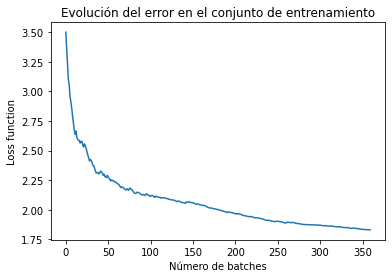

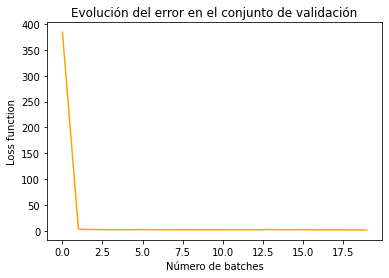

In [14]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(t_loss)
plt.ylabel('Loss function')
plt.xlabel('Número de batches')
plt.title('Evolución del error en el conjunto de entrenamiento')

plt.figure()
plt.plot(v_loss,c='orange')
plt.ylabel('Loss function')
plt.xlabel('Número de batches')
plt.title('Evolución del error en el conjunto de validación')

# Función auxiliar para transformar las imagenes

In [15]:
def transformar(img):
    if img.shape[1]==3:
        return img.squeeze().permute(1, 2, 0).numpy()
    elif img.shape[1]==12:
        img = np.transpose(img) #(1242, 375, 12, 1)
        img = img.squeeze() #(1242, 375, 12)
        img = np.argmax(img,axis=2).astype(np.ubyte)
        return img
    else:
        img = img.permute(1, 2, 0).numpy().squeeze().astype(np.ubyte)
        return img

# Cargamos los checkpoints

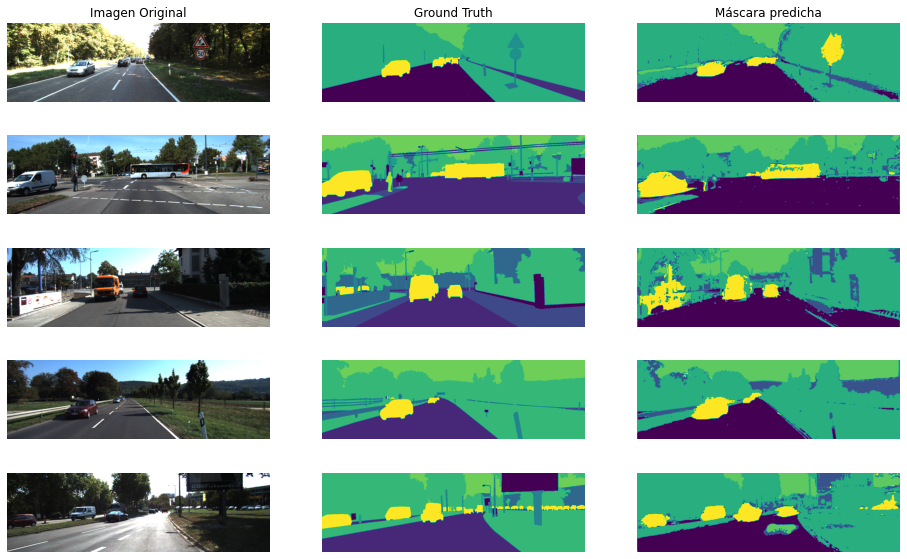

In [16]:
import matplotlib.pyplot as plt

dir_img = Path('/content/Pytorch-UNet/training/image_2/')
dir_mask = Path('/content/Pytorch-UNet/training/semantic/')
checkpoint_file = '/content/Pytorch-UNet/checkpoints/checkpoint_epoch2.pth'

dataset_global = KittiDataset(dir_img, dir_mask, 'gray', scale = 1.0)

net = UNet(n_channels=3, n_classes=12, bilinear = True)

device = torch.device('cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(checkpoint_file, map_location=device))

net.cpu()

fig, ((ax1, ax2,ax3), (ax4, ax5,ax6), (ax7, ax8,ax9),(ax10, ax11,ax12),(ax13, ax14,ax15)) = plt.subplots(5,3, figsize=(16,10))

axes = [(ax1, ax2,ax3), (ax4, ax5,ax6), (ax7, ax8,ax9),(ax10, ax11,ax12),(ax13, ax14,ax15)]
n=10
j=0
for i in range(n,n+5):

  axa = axes[j][0]
  axb = axes[j][1]
  axc = axes[j][2]
  mysize = dataset_global[i]['image'].size()

  if j==0:
    axa.set_title('Imagen Original')
    axb.set_title('Ground Truth')
    axc.set_title('Máscara predicha')

  img_global = dataset_global[i]['image'].reshape((1,mysize[0],mysize[1],mysize[2])) #.cuda()
  img_gmask = dataset_global[i]['mask'].reshape((1,mysize[1],mysize[2])) #.cuda()

  #print("Tamaño del tensor de entrada:", img_global.size())
  img_pred = net.forward(img_global)
  img_np = img_pred.cpu().detach().numpy()
  #print("Tamaño del tensor de salida:", img_pred.size())

  # Por hacer: dibujar img_global, img_gmask y img_np usando plt.imshow()
  # Para esto, es necesario modificar las dimensiones de las imágenes, y transformar
  # las imágenes que contienen labels a formato np.ubyte
  # Además img_global debe ser multiplicada por 255
  axa.imshow(transformar(img_global))
  axb.imshow(transformar(img_gmask))
  axc.imshow(np.transpose(transformar(img_np))) # (W,H)
  axa.axis("off")
  axb.axis("off")
  axc.axis("off")
  j+=1
  

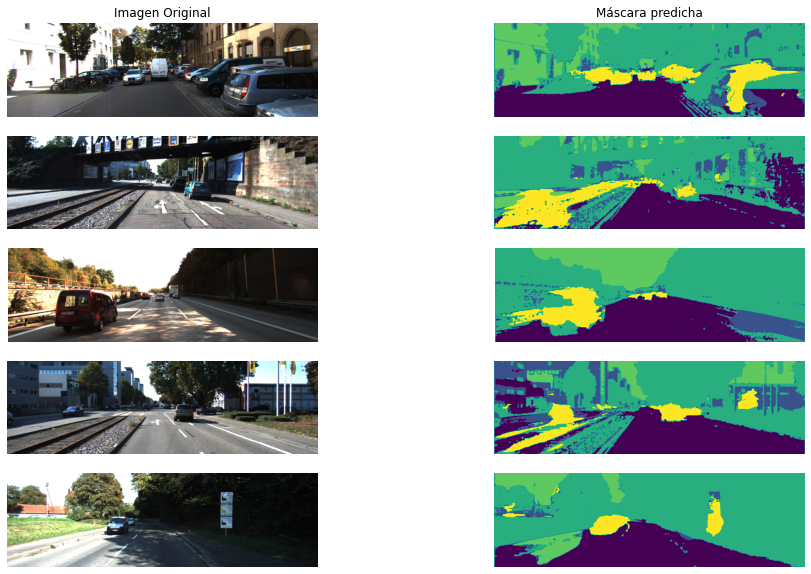

In [17]:
import matplotlib.pyplot as plt

dir_img = Path('/content/Pytorch-UNet/testing/image_2/')
dir_mask = Path('/content/Pytorch-UNet/training/semantic/')
checkpoint_file = '/content/Pytorch-UNet/checkpoints/checkpoint_epoch2.pth'

dataset_global = KittiDataset(dir_img, dir_mask, 'gray', scale = 1.0)

net = UNet(n_channels=3, n_classes=12, bilinear = True)

device = torch.device('cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(checkpoint_file, map_location=device))

net.cpu()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8),(ax9, ax10)) = plt.subplots(5,2, figsize=(16,10))

axes = [(ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8),(ax9, ax10)]
n=15
j=0
for i in range(n,n+5):


  axa = axes[j][0]
  axb = axes[j][1]

  if j==0:
    axa.set_title('Imagen Original')
    #axb.set_title('Ground Truth')
    axb.set_title('Máscara predicha')

  mysize = dataset_global[i]['image'].size()

  img_global = dataset_global[i]['image'].reshape((1,mysize[0],mysize[1],mysize[2])) #.cuda()
  #img_gmask = dataset_global[i]['mask'].reshape((1,mysize[1],mysize[2])) #.cuda()

  #print("Tamaño del tensor de entrada:", img_global.size())
  img_pred = net.forward(img_global)
  img_np = img_pred.cpu().detach().numpy()
  #print("Tamaño del tensor de salida:", img_pred.size())

  # Por hacer: dibujar img_global, img_gmask y img_np usando plt.imshow()
  # Para esto, es necesario modificar las dimensiones de las imágenes, y transformar
  # las imágenes que contienen labels a formato np.ubyte
  # Además img_global debe ser multiplicada por 255
  axa.imshow(transformar(img_global))
  axb.imshow(np.transpose(transformar(img_np))) # (W,H)
  axa.axis("off")
  axb.axis("off")
  j+=1

# item 9

Usando red u-net con sólo 3 capas Up y 3 capas Down

In [18]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from utils.dice_score import dice_loss
dir_img = Path('./training/image_2/')
dir_mask = Path('./training/semantic/')
dir_checkpoint = Path('./checkpoints/')


if __name__ == '__main__':
    args = get_args_train()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    net2 = UNet2(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)

    logging.info(f'Network:\n'
                 f'\t{net2.n_channels} input channels\n'
                 f'\t{net2.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if net2.bilinear else "Transposed conv"} upscaling')

    if args.load:
        net2.load_state_dict(torch.load(args.load, map_location=device))
        logging.info(f'Model loaded from {args.load}')

    net2.to(device=device)
    try:
        t_loss2,v_loss2 = train_net(net=net2,
                  epochs=args.epochs,
                  batch_size=args.batch_size,
                  learning_rate=args.lr,
                  device=device,
                  img_scale=args.scale,
                  val_percent=args.val / 100,
                  amp=args.amp)
    except KeyboardInterrupt:
        torch.save(net2.state_dict(), 'INTERRUPTED.pth')
        logging.info('Saved interrupt')
        raise

Largo dataset: 200


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
learning rate,███████████████▂▂▂▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▆▄▅▃▃▅▃▃█▄▅▂▄▄▄▂▂▆▁▃▂▂▅▃▃▁▄▁▂▆▃▄▂▂▃▃▅▃▂▂
validation Dice,▁▅▅▅▆▅▇▇▇█▇▆█▇▇▆████
epoch,2
learning rate,0.0
step,360
train loss,1.39628
validation Dice,0.48784


Epoch 2/2: 100%|██████████| 180/180 [01:32<00:00,  1.95img/s, loss (batch)=1.98]


Text(0.5, 1.0, 'Evolución del error en el conjunto de validación')

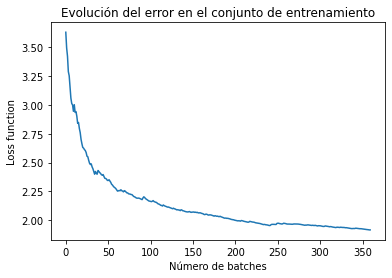

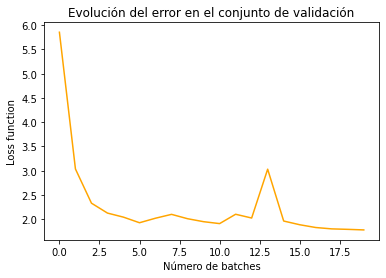

In [19]:
plt.figure()
plt.plot(t_loss2)
plt.ylabel('Loss function')
plt.xlabel('Número de batches')
plt.title('Evolución del error en el conjunto de entrenamiento')

plt.figure()
plt.plot(v_loss2,c='orange')
plt.ylabel('Loss function')
plt.xlabel('Número de batches')
plt.title('Evolución del error en el conjunto de validación')

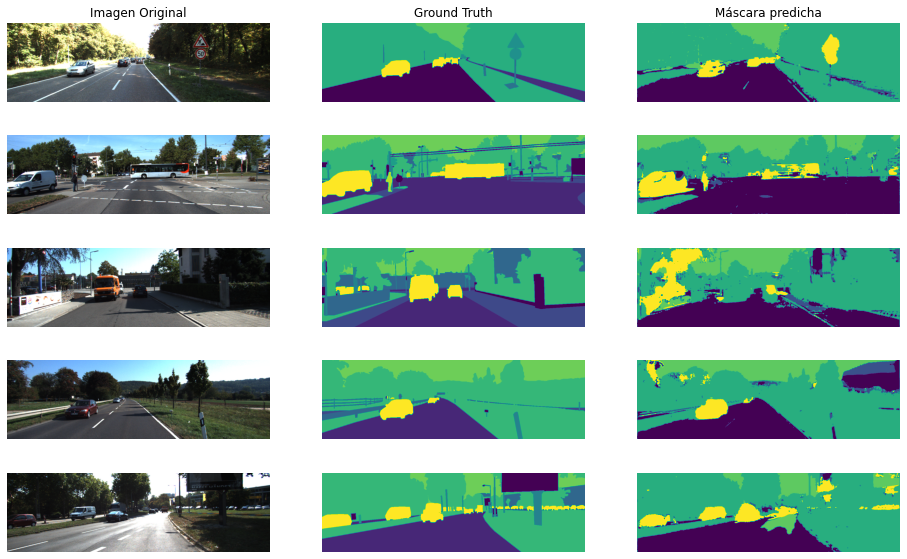

In [20]:
import matplotlib.pyplot as plt

dir_img = Path('/content/Pytorch-UNet/training/image_2/')
dir_mask = Path('/content/Pytorch-UNet/training/semantic/')
checkpoint_file = '/content/Pytorch-UNet/checkpoints/checkpoint_epoch2.pth'

dataset_global = KittiDataset(dir_img, dir_mask, 'gray', scale = 1.0)

net = UNet2(n_channels=3, n_classes=12, bilinear = True)

device = torch.device('cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(checkpoint_file, map_location=device))

net.cpu()

fig, ((ax1, ax2,ax3), (ax4, ax5,ax6), (ax7, ax8,ax9),(ax10, ax11,ax12),(ax13, ax14,ax15)) = plt.subplots(5,3, figsize=(16,10))

axes = [(ax1, ax2,ax3), (ax4, ax5,ax6), (ax7, ax8,ax9),(ax10, ax11,ax12),(ax13, ax14,ax15)]
n=10
j=0
for i in range(n,n+5):

  axa = axes[j][0]
  axb = axes[j][1]
  axc = axes[j][2]
  mysize = dataset_global[i]['image'].size()

  if j==0:
    axa.set_title('Imagen Original')
    axb.set_title('Ground Truth')
    axc.set_title('Máscara predicha')

  img_global = dataset_global[i]['image'].reshape((1,mysize[0],mysize[1],mysize[2])) #.cuda()
  img_gmask = dataset_global[i]['mask'].reshape((1,mysize[1],mysize[2])) #.cuda()

  #print("Tamaño del tensor de entrada:", img_global.size())
  img_pred = net.forward(img_global)
  img_np = img_pred.cpu().detach().numpy()
  #print("Tamaño del tensor de salida:", img_pred.size())

  # Por hacer: dibujar img_global, img_gmask y img_np usando plt.imshow()
  # Para esto, es necesario modificar las dimensiones de las imágenes, y transformar
  # las imágenes que contienen labels a formato np.ubyte
  # Además img_global debe ser multiplicada por 255
  axa.imshow(transformar(img_global))
  axb.imshow(transformar(img_gmask))
  axc.imshow(np.transpose(transformar(img_np))) # (W,H)
  axa.axis("off")
  axb.axis("off")
  axc.axis("off")
  j+=1
  

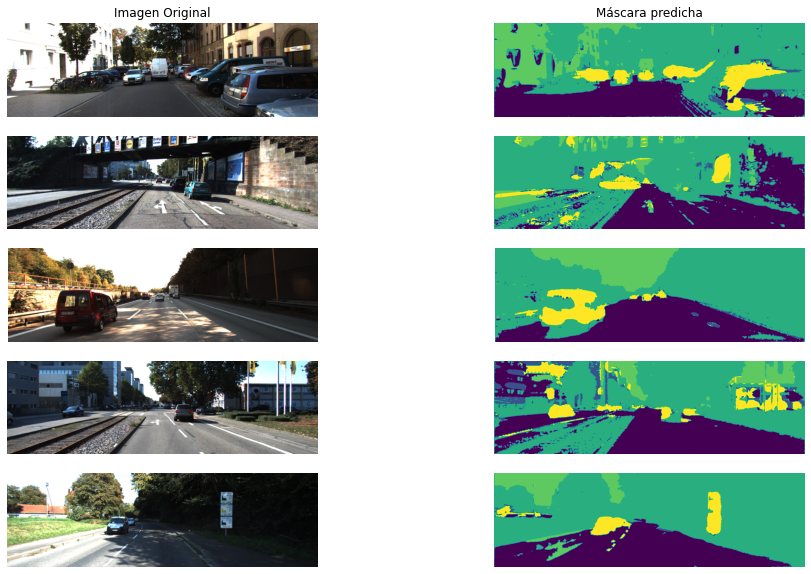

In [21]:
import matplotlib.pyplot as plt

dir_img = Path('/content/Pytorch-UNet/testing/image_2/')
dir_mask = Path('/content/Pytorch-UNet/training/semantic/')
checkpoint_file = '/content/Pytorch-UNet/checkpoints/checkpoint_epoch2.pth'

dataset_global = KittiDataset(dir_img, dir_mask, 'gray', scale = 1.0)

net = UNet2(n_channels=3, n_classes=12, bilinear = True)

device = torch.device('cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(checkpoint_file, map_location=device))

net.cpu()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8),(ax9, ax10)) = plt.subplots(5,2, figsize=(16,10))

axes = [(ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8),(ax9, ax10)]
n=15
j=0
for i in range(n,n+5):


  axa = axes[j][0]
  axb = axes[j][1]

  if j==0:
    axa.set_title('Imagen Original')
    #axb.set_title('Ground Truth')
    axb.set_title('Máscara predicha')

  mysize = dataset_global[i]['image'].size()

  img_global = dataset_global[i]['image'].reshape((1,mysize[0],mysize[1],mysize[2])) #.cuda()
  #img_gmask = dataset_global[i]['mask'].reshape((1,mysize[1],mysize[2])) #.cuda()

  #print("Tamaño del tensor de entrada:", img_global.size())
  img_pred = net.forward(img_global)
  img_np = img_pred.cpu().detach().numpy()
  #print("Tamaño del tensor de salida:", img_pred.size())

  # Por hacer: dibujar img_global, img_gmask y img_np usando plt.imshow()
  # Para esto, es necesario modificar las dimensiones de las imágenes, y transformar
  # las imágenes que contienen labels a formato np.ubyte
  # Además img_global debe ser multiplicada por 255
  axa.imshow(transformar(img_global))
  axb.imshow(np.transpose(transformar(img_np))) # (W,H)
  axa.axis("off")
  axb.axis("off")
  j+=1

In [22]:
import argparse
import logging
import sys
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch import optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from utils.dice_score import dice_loss
dir_img = Path('./training/image_2/')
dir_mask = Path('./training/semantic/')
dir_checkpoint = Path('./checkpoints/')


if __name__ == '__main__':
    args = get_args_train()

    logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    logging.info(f'Using device {device}')

    # Change here to adapt to your data
    # n_channels=3 for RGB images
    # n_classes is the number of probabilities you want to get per pixel
    net3 = UNet3(n_channels=3, n_classes=args.classes, bilinear=args.bilinear)

    logging.info(f'Network:\n'
                 f'\t{net3.n_channels} input channels\n'
                 f'\t{net3.n_classes} output channels (classes)\n'
                 f'\t{"Bilinear" if net3.bilinear else "Transposed conv"} upscaling')

    if args.load:
        net3.load_state_dict(torch.load(args.load, map_location=device))
        logging.info(f'Model loaded from {args.load}')

    net3.to(device=device)
    try:
        t_loss3,v_loss3 = train_net(net=net3,
                  epochs=args.epochs,
                  batch_size=args.batch_size,
                  learning_rate=args.lr,
                  device=device,
                  img_scale=args.scale,
                  val_percent=args.val / 100,
                  amp=args.amp)
    except KeyboardInterrupt:
        torch.save(net3.state_dict(), 'INTERRUPTED.pth')
        logging.info('Saved interrupt')
        raise

Largo dataset: 200


epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████████
learning rate,█████████████▁▁▁▁▁▁▁
step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train loss,▆▄▃▂▄▄▃▅▄▂█▆▂▂▆▃▁▄▂▁▁▄▃▂▁▂▁▃▁▃▂▅▁▁▁▄▃▄▂▃
validation Dice,▁▄▅▆▇▇▇▆█▇█▆▇▅▇█████
epoch,2
learning rate,1e-05
step,360
train loss,1.98049
validation Dice,0.45545


Epoch 2/2: 100%|██████████| 180/180 [01:12<00:00,  2.47img/s, loss (batch)=1.42]


Text(0.5, 1.0, 'Evolución del error en el conjunto de validación')

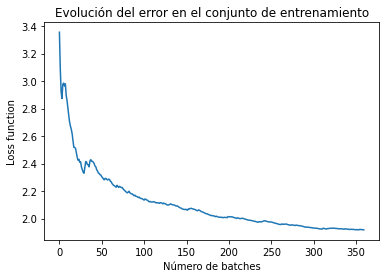

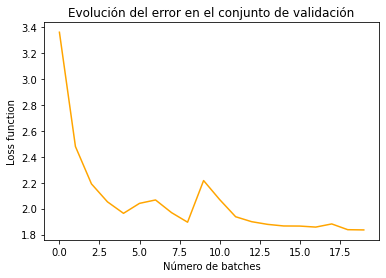

In [23]:
plt.figure()
plt.plot(t_loss3)
plt.ylabel('Loss function')
plt.xlabel('Número de batches')
plt.title('Evolución del error en el conjunto de entrenamiento')

plt.figure()
plt.plot(v_loss3,c='orange')
plt.ylabel('Loss function')
plt.xlabel('Número de batches')
plt.title('Evolución del error en el conjunto de validación')

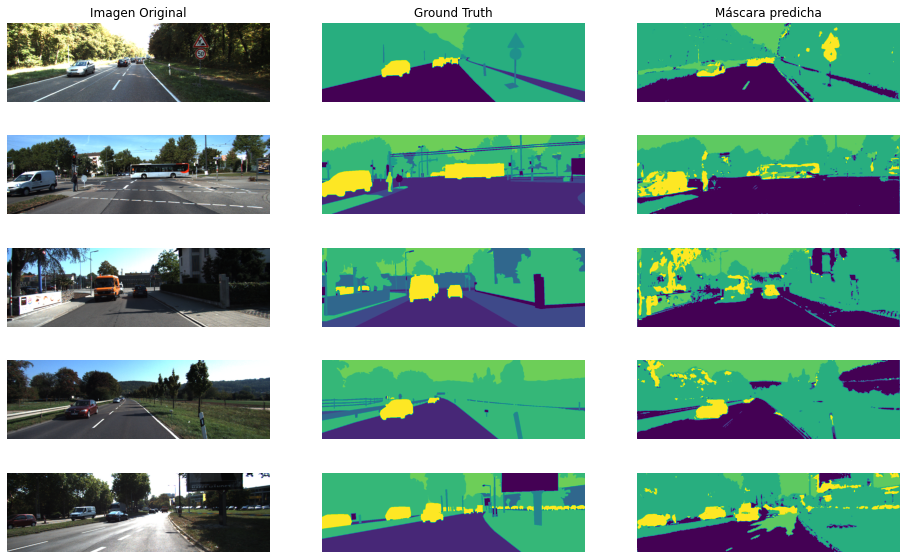

In [24]:
import matplotlib.pyplot as plt

dir_img = Path('/content/Pytorch-UNet/training/image_2/')
dir_mask = Path('/content/Pytorch-UNet/training/semantic/')
checkpoint_file = '/content/Pytorch-UNet/checkpoints/checkpoint_epoch2.pth'

dataset_global = KittiDataset(dir_img, dir_mask, 'gray', scale = 1.0)

net = UNet3(n_channels=3, n_classes=12, bilinear = True)

device = torch.device('cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(checkpoint_file, map_location=device))

net.cpu()

fig, ((ax1, ax2,ax3), (ax4, ax5,ax6), (ax7, ax8,ax9),(ax10, ax11,ax12),(ax13, ax14,ax15)) = plt.subplots(5,3, figsize=(16,10))

axes = [(ax1, ax2,ax3), (ax4, ax5,ax6), (ax7, ax8,ax9),(ax10, ax11,ax12),(ax13, ax14,ax15)]
n=10
j=0
for i in range(n,n+5):

  axa = axes[j][0]
  axb = axes[j][1]
  axc = axes[j][2]
  mysize = dataset_global[i]['image'].size()

  if j==0:
    axa.set_title('Imagen Original')
    axb.set_title('Ground Truth')
    axc.set_title('Máscara predicha')

  img_global = dataset_global[i]['image'].reshape((1,mysize[0],mysize[1],mysize[2])) #.cuda()
  img_gmask = dataset_global[i]['mask'].reshape((1,mysize[1],mysize[2])) #.cuda()

  #print("Tamaño del tensor de entrada:", img_global.size())
  img_pred = net.forward(img_global)
  img_np = img_pred.cpu().detach().numpy()
  #print("Tamaño del tensor de salida:", img_pred.size())

  # Por hacer: dibujar img_global, img_gmask y img_np usando plt.imshow()
  # Para esto, es necesario modificar las dimensiones de las imágenes, y transformar
  # las imágenes que contienen labels a formato np.ubyte
  # Además img_global debe ser multiplicada por 255
  axa.imshow(transformar(img_global))
  axb.imshow(transformar(img_gmask))
  axc.imshow(np.transpose(transformar(img_np))) # (W,H)
  axa.axis("off")
  axb.axis("off")
  axc.axis("off")
  j+=1
  

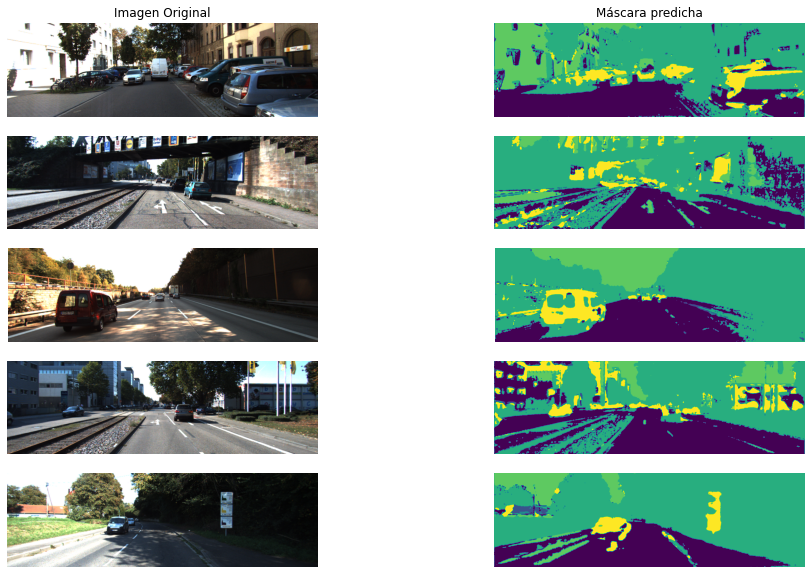

In [25]:
import matplotlib.pyplot as plt

dir_img = Path('/content/Pytorch-UNet/testing/image_2/')
dir_mask = Path('/content/Pytorch-UNet/training/semantic/')
checkpoint_file = '/content/Pytorch-UNet/checkpoints/checkpoint_epoch2.pth'

dataset_global = KittiDataset(dir_img, dir_mask, 'gray', scale = 1.0)

net = UNet3(n_channels=3, n_classes=12, bilinear = True)

device = torch.device('cpu')
logging.info(f'Using device {device}')
net.to(device=device)
net.load_state_dict(torch.load(checkpoint_file, map_location=device))

net.cpu()

fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8),(ax9, ax10)) = plt.subplots(5,2, figsize=(16,10))

axes = [(ax1, ax2), (ax3, ax4), (ax5, ax6),(ax7, ax8),(ax9, ax10)]
n=15
j=0
for i in range(n,n+5):


  axa = axes[j][0]
  axb = axes[j][1]

  if j==0:
    axa.set_title('Imagen Original')
    #axb.set_title('Ground Truth')
    axb.set_title('Máscara predicha')

  mysize = dataset_global[i]['image'].size()

  img_global = dataset_global[i]['image'].reshape((1,mysize[0],mysize[1],mysize[2])) #.cuda()
  #img_gmask = dataset_global[i]['mask'].reshape((1,mysize[1],mysize[2])) #.cuda()

  #print("Tamaño del tensor de entrada:", img_global.size())
  img_pred = net.forward(img_global)
  img_np = img_pred.cpu().detach().numpy()
  #print("Tamaño del tensor de salida:", img_pred.size())

  # Por hacer: dibujar img_global, img_gmask y img_np usando plt.imshow()
  # Para esto, es necesario modificar las dimensiones de las imágenes, y transformar
  # las imágenes que contienen labels a formato np.ubyte
  # Además img_global debe ser multiplicada por 255
  axa.imshow(transformar(img_global))
  axb.imshow(np.transpose(transformar(img_np))) # (W,H)
  axa.axis("off")
  axb.axis("off")
  j+=1

Text(0.5, 1.0, 'Evolución del error en el conjunto de validación')

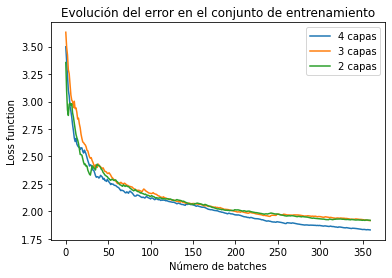

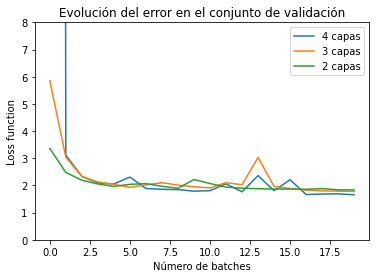

In [34]:
plt.figure()
plt.plot(t_loss,label='4 capas')
plt.plot(t_loss2,label='3 capas')
plt.plot(t_loss3,label='2 capas')
plt.ylabel('Loss function')
plt.xlabel('Número de batches')
plt.title('Evolución del error en el conjunto de entrenamiento')
plt.legend()

plt.figure()
plt.plot(v_loss,label='4 capas')
plt.plot(v_loss2,label='3 capas')
plt.plot(v_loss3,label='2 capas')
plt.ylabel('Loss function')
plt.xlabel('Número de batches')
plt.ylim(0,8)
plt.legend()
plt.title('Evolución del error en el conjunto de validación')